In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sc
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
import h5py
from data_analysis_codes.tools import ReadingTools as RRead
from data_analysis_codes.tools import FD as FD_file
from data_analysis_codes.tools import Cstyle
plt.style.use(Cstyle.style1)
home_path = '/home/robynm/simulations/Geometrical/'
sciama_path = '/mnt/lustre/munozr/runs/Geometrical/'
path = sciama_path
simname = 'PlaneWave'
import time
import pandas as pd

In [2]:
ic = 4
allNs = [int(np.ceil(i)) for i in np.geomspace(13, 150, 30)]
meanerror_4R = []
meanerror_BID = []
meanerror_B2 = []
meanerror_BT = []
meanerror_E2 = []
meanerror_ET = []
meanerror_B2vsE2 = []
meanerror_E2vsB2 = []
timelog = []
for N in allNs:
    start_time = time.time()
    L = 20
    dx = L/N
    xyz = np.arange(-L/2, L/2, dx)[:N]
    x, y, z = np.meshgrid(xyz, xyz, xyz, indexing='ij')
    Box_zero = np.zeros([N, N, N])
    Box_ones = np.ones([N, N, N])
    
    RRead.BASH('mkdir '+path+simname+'_N'+str(N))
    RRead.BASH('mkdir '+path+simname+'_N'+str(N)+'/all_iterations')    
    dtfac = 0.05
    dt = dx*dtfac
    t_array = np.arange(1.5-ic*dt, 1.5+dt, dt)
    for it, t in enumerate(t_array):
        r = 1/2
        b = np.sqrt(4*r*(1-r))
        beta = 0.0
        A = 1.0
        B = b*(x+np.log(t))
        C = 0.0
        gdown = np.array([[(t**2)*Box_ones, Box_zero, Box_zero],
                          [Box_zero, (t**(2*r))*(np.exp(2*r*x))*(A*A*np.exp(beta)+C*C*np.exp(-beta)), (t**(2*r))*(np.exp(2*r*x))*(A*B*np.exp(beta)+A*C*np.exp(-beta))],
                          [Box_zero, (t**(2*r))*(np.exp(2*r*x))*(A*B*np.exp(beta)+A*C*np.exp(-beta)), (t**(2*r))*(np.exp(2*r*x))*(B*B*np.exp(beta)+A*A*np.exp(-beta))]])

        dtA = 0.0
        dtB = b/t
        dtC = 0.0
        Kdown = (-1/2)*np.array([[2*t*Box_ones, Box_zero, Box_zero],
                                 [Box_zero, 2*r*(t**(2*r-1))*(np.exp(2*r*x))*(A*A*np.exp(beta)+C*C*np.exp(-beta))+(t**(2*r))*(np.exp(2*r*x))*(2*A*dtA*np.exp(beta)+2*C*dtC*np.exp(-beta)), 2*r*(t**(2*r-1))*(np.exp(2*r*x))*(A*B*np.exp(beta)+A*C*np.exp(-beta))+(t**(2*r))*(np.exp(2*r*x))*(dtA*B*np.exp(beta)+A*dtB*np.exp(beta)+dtA*C*np.exp(-beta)+A*dtC*np.exp(-beta))],
                                 [Box_zero, 2*r*(t**(2*r-1))*(np.exp(2*r*x))*(A*B*np.exp(beta)+A*C*np.exp(-beta))+(t**(2*r))*(np.exp(2*r*x))*(dtA*B*np.exp(beta)+A*dtB*np.exp(beta)+dtA*C*np.exp(-beta)+A*dtC*np.exp(-beta)), 2*r*(t**(2*r-1))*(np.exp(2*r*x))*(B*B*np.exp(beta)+A*A*np.exp(-beta))+(t**(2*r))*(np.exp(2*r*x))*(2*B*dtB*np.exp(beta)+2*A*dtA*np.exp(-beta))]])
        
        fname = path+simname+'_N'+str(N)+'/all_iterations/'+simname+'_it_{:06d}.hdf5'.format(it)
        with h5py.File(fname, 'w') as fnew:
            fnew['gxx it={}'.format(it)] = gdown[0,0]
            fnew['gxy it={}'.format(it)] = gdown[0,1]
            fnew['gxz it={}'.format(it)] = gdown[0,2]
            fnew['gyy it={}'.format(it)] = gdown[1,1]
            fnew['gyz it={}'.format(it)] = gdown[1,2]
            fnew['gzz it={}'.format(it)] = gdown[2,2]
            fnew['kxx it={}'.format(it)] = Kdown[0,0]
            fnew['kxy it={}'.format(it)] = Kdown[0,1]
            fnew['kxz it={}'.format(it)] = Kdown[0,2]
            fnew['kyy it={}'.format(it)] = Kdown[1,1]
            fnew['kyz it={}'.format(it)] = Kdown[1,2]
            fnew['kzz it={}'.format(it)] = Kdown[2,2]

    RRead.BASH("""printf "%s\n" "simname  = '"""+simname+"""'" "N = """+str(N)+"""" "L = """+str(L)+"""" "dtfac = """+str(dtfac)+"""" "boundary = False" "data_path = '"""+path+simname+'_N'+str(N)+"""/'"> data_analysis_codes/EBWeylparam.py""")
    RRead.BASH("python data_analysis_codes/EBWeyl_test.py")
    
    t = 1.5
    it = np.argmin(abs(t_array-t))
    fname = path+simname+'_N'+str(N)+'/EBWeyl/it={:06d}.hdf5'.format(it)
    f = h5py.File(fname, 'r')
    
    meanerror_4R += [np.mean(np.ma.masked_invalid(abs(np.array(f['RicciS4'])[ic:-ic,ic:-ic,ic:-ic])))]
    meanerror_BID += [np.mean(np.ma.masked_invalid(abs(np.array(f['Bianchi_ID'])[ic:-ic,ic:-ic,ic:-ic])))]
    
    B2th = Box_ones/(2*(t**4))
    meanerror_B2 += [np.mean(np.ma.masked_invalid(abs(np.array(f['B2'])/B2th - 1)[ic:-ic,ic:-ic,ic:-ic]))]
    meanerror_BT += [np.mean(np.ma.masked_invalid(abs(np.array(f['Btrace'])[ic:-ic,ic:-ic,ic:-ic])))]
    
    E2th = Box_ones/(2*(t**4))
    meanerror_E2 += [np.mean(np.ma.masked_invalid(abs(np.array(f['E2'])/E2th - 1)[ic:-ic,ic:-ic,ic:-ic]))]
    meanerror_ET += [np.mean(np.ma.masked_invalid(abs(np.array(f['Etrace'])[ic:-ic,ic:-ic,ic:-ic])))]
    
    meanerror_B2vsE2 += [np.mean(np.ma.masked_invalid(abs(np.array(f['B2'])/np.array(f['E2']) - 1)[ic:-ic,ic:-ic,ic:-ic]))]
    meanerror_E2vsB2 += [np.mean(np.ma.masked_invalid(abs(np.array(f['E2'])/np.array(f['B2']) - 1)[ic:-ic,ic:-ic,ic:-ic]))]
    
    timelog += [(time.time() - start_time)/60]
    print('N={}, T={:.2f}, error={:.2e}, {:.2e}, {:.2e}, {:.2e}, {:.2e}, {:.2e}'.format(N, timelog[-1], meanerror_4R[-1], meanerror_B2[-1], meanerror_BT[-1], meanerror_E2[-1], meanerror_ET[-1], meanerror_BID[-1]))
    RRead.BASH('rm -rf '+path+simname+'_N'+str(N))

N=13, T=0.05, error=3.76e+00, 6.12e+01, 2.91e+00, 1.18e+02, 1.27e-15, 1.67e+01
N=15, T=0.05, error=2.24e+00, 1.19e+01, 1.43e+00, 5.12e+00, 1.34e-15, 1.76e+01
N=16, T=0.17, error=1.72e+00, 5.22e+00, 1.05e+00, 3.80e-01, 1.03e-15, 1.77e+01
N=17, T=0.08, error=1.34e+00, 2.11e+00, 7.93e-01, 7.26e-01, 6.21e-16, 1.76e+01
N=19, T=0.15, error=8.38e-01, 7.24e-02, 4.76e-01, 8.32e-01, 4.71e-16, 1.71e+01
N=20, T=0.07, error=6.74e-01, 3.89e-01, 3.78e-01, 7.16e-01, 3.42e-16, 1.66e+01
N=22, T=0.08, error=4.50e-01, 5.46e-01, 2.48e-01, 5.03e-01, 4.22e-16, 1.56e+01
N=24, T=0.20, error=3.11e-01, 4.94e-01, 1.69e-01, 3.55e-01, 6.14e-16, 1.44e+01
N=26, T=0.11, error=2.22e-01, 4.04e-01, 1.20e-01, 2.56e-01, 4.05e-16, 1.32e+01
N=28, T=0.12, error=1.63e-01, 3.20e-01, 8.75e-02, 1.89e-01, 6.76e-16, 1.19e+01
N=31, T=0.22, error=1.06e-01, 2.25e-01, 5.69e-02, 1.24e-01, 3.68e-16, 1.02e+01
N=33, T=0.16, error=8.21e-02, 1.78e-01, 4.38e-02, 9.60e-02, 8.50e-16, 9.22e+00
N=36, T=0.21, error=5.73e-02, 1.28e-01, 3.05e-02, 6.

In [3]:
data = np.array([allNs, timelog]).T
columns = ['N', 'Time']
pd.DataFrame(data, columns=columns).to_csv('ErrorData/PlaneWave_Geometric_Time.csv')

<IPython.core.display.Javascript object>


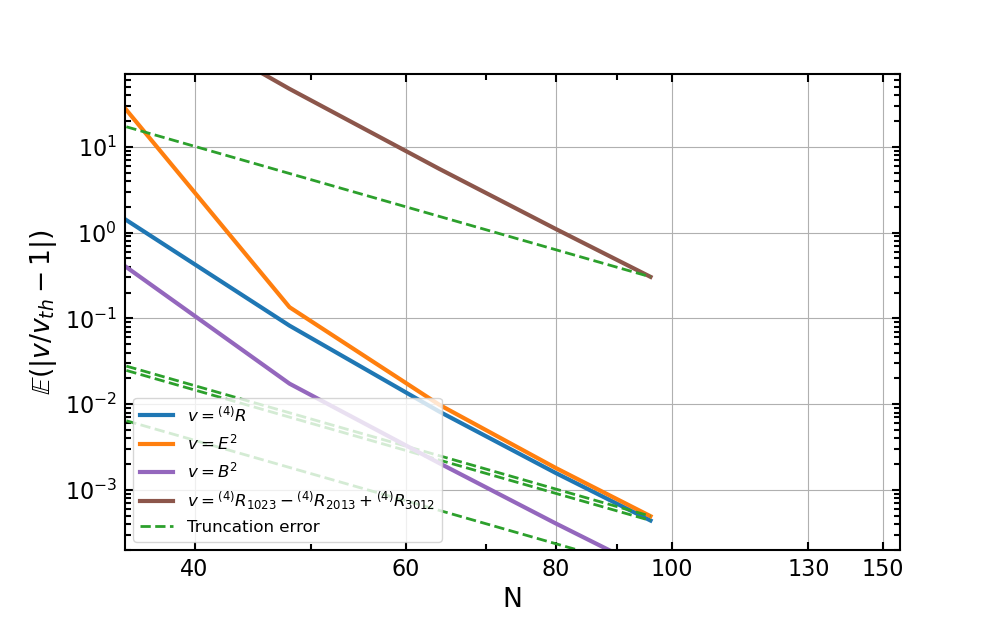

Text(0, 0.5, '$\\mathbb{E}\\left(|v/v_{th}-1|\\right)$')

In [3]:
idec = -1

phi = (1+np.sqrt(5))/2
plt.figure(figsize=(10,10/phi))

plt.loglog(allNs, meanerror_4R, 'C0', label=r'$v={}^{(4)}R$')
yplot_4th_order_decrease = [meanerror_4R[idec]*((allNs[idec]/N)**4) for N in allNs]
plt.loglog(allNs, yplot_4th_order_decrease, 'C2--', linewidth = 2)

plt.loglog(allNs, meanerror_E2, 'C1', label=r'$v=E^2$')
yplot_4th_order_decrease = [meanerror_E2[idec]*((allNs[idec]/N)**4) for N in allNs]
plt.loglog(allNs, yplot_4th_order_decrease, 'C2--', linewidth = 2)

plt.loglog(allNs, meanerror_B2, 'C4', label=r'$v=B^2$')
yplot_4th_order_decrease = [meanerror_B2[idec]*((allNs[idec]/N)**4) for N in allNs]
plt.loglog(allNs, yplot_4th_order_decrease, 'C2--', linewidth = 2)

plt.loglog(allNs, meanerror_BID, 'C5', label=r'$v={}^{(4)}R_{1023} - {}^{(4)}R_{2013} + {}^{(4)}R_{3012}$')
yplot_4th_order_decrease = [meanerror_BID[idec]*((allNs[idec]/N)**4) for N in allNs]
plt.loglog(allNs, yplot_4th_order_decrease, 'C2--', linewidth = 2, label='Truncation error')

plt.legend(loc=3, prop={'size': 12})
plt.grid()
plt.xlabel('N')
plt.ylim(2e-4, 7e1)
plt.xticks([30,40,60,80,100,130,150], ['30','40','60','80','100','130','150'])
plt.xlim(35, 155)
plt.ylabel(r'$\mathbb{E}\left(|v/v_{th}-1|\right)$')

<IPython.core.display.Javascript object>


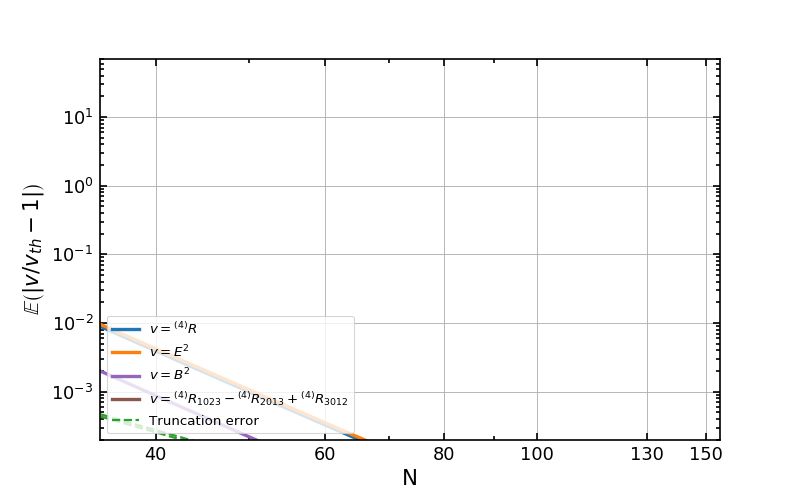

Text(0, 0.5, '$\\mathbb{E}\\left(|v/v_{th}-1|\\right)$')

In [6]:
idec = -1

phi = (1+np.sqrt(5))/2
plt.figure(figsize=(10,10/phi))

plt.loglog(allNs, meanerror_4R, 'C0', label=r'$v={}^{(4)}R$')
yplot_4th_order_decrease = [meanerror_4R[idec]*((allNs[idec]/N)**4) for N in allNs]
plt.loglog(allNs, yplot_4th_order_decrease, 'C2--', linewidth = 2)

plt.loglog(allNs, meanerror_E2, 'C1', label=r'$v=E^2$')
yplot_4th_order_decrease = [meanerror_E2[idec]*((allNs[idec]/N)**4) for N in allNs]
plt.loglog(allNs, yplot_4th_order_decrease, 'C2--', linewidth = 2)

plt.loglog(allNs, meanerror_B2, 'C4', label=r'$v=B^2$')
yplot_4th_order_decrease = [meanerror_B2[idec]*((allNs[idec]/N)**4) for N in allNs]
plt.loglog(allNs, yplot_4th_order_decrease, 'C2--', linewidth = 2)

plt.loglog(allNs, meanerror_BID, 'C5', label=r'$v={}^{(4)}R_{1023} - {}^{(4)}R_{2013} + {}^{(4)}R_{3012}$')
yplot_4th_order_decrease = [meanerror_BID[idec]*((allNs[idec]/N)**4) for N in allNs]
plt.loglog(allNs, yplot_4th_order_decrease, 'C2--', linewidth = 2, label='Truncation error')

plt.legend(loc=3, prop={'size': 12})
plt.grid()
plt.xlabel('N')
plt.ylim(2e-4, 7e1)
plt.xticks([30,40,60,80,100,130,150], ['30','40','60','80','100','130','150'])
plt.xlim(35, 155)
plt.ylabel(r'$\mathbb{E}\left(|v/v_{th}-1|\right)$')

<IPython.core.display.Javascript object>


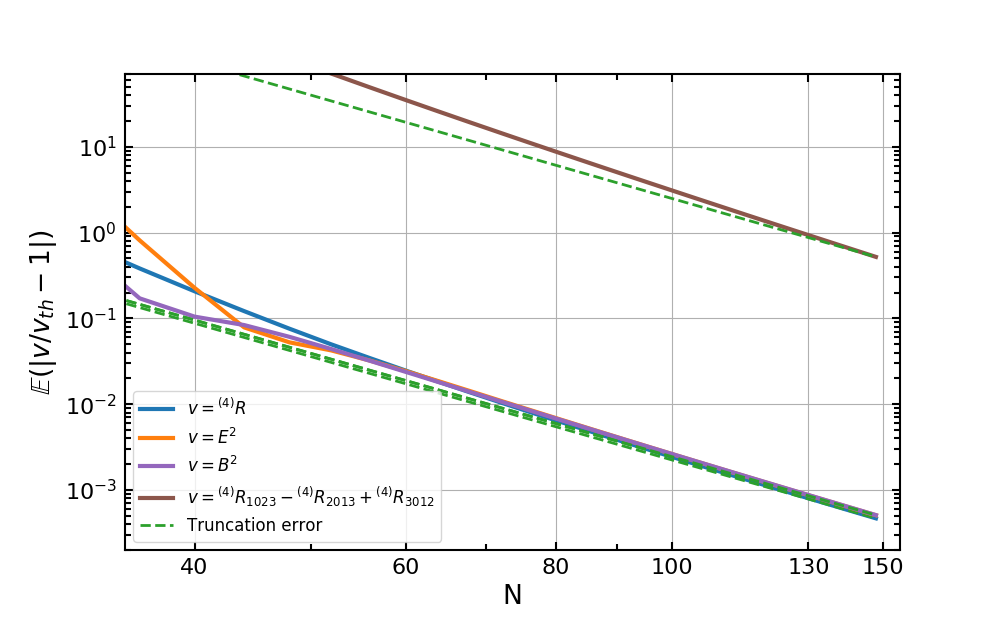

In [11]:
idec = -1

phi = (1+np.sqrt(5))/2
plt.figure(figsize=(10,10/phi))

plt.loglog(allNs, meanerror_4R, 'C0', label=r'$v={}^{(4)}R$')
yplot_4th_order_decrease = [meanerror_4R[idec]*((allNs[idec]/N)**4) for N in allNs]
plt.loglog(allNs, yplot_4th_order_decrease, 'C2--', linewidth = 2)

plt.loglog(allNs, meanerror_E2, 'C1', label=r'$v=E^2$')
yplot_4th_order_decrease = [meanerror_E2[idec]*((allNs[idec]/N)**4) for N in allNs]
plt.loglog(allNs, yplot_4th_order_decrease, 'C2--', linewidth = 2)

plt.loglog(allNs, meanerror_B2, 'C4', label=r'$v=B^2$')
yplot_4th_order_decrease = [meanerror_B2[idec]*((allNs[idec]/N)**4) for N in allNs]
plt.loglog(allNs, yplot_4th_order_decrease, 'C2--', linewidth = 2)

plt.loglog(allNs, meanerror_BID, 'C5', label=r'$v={}^{(4)}R_{1023} - {}^{(4)}R_{2013} + {}^{(4)}R_{3012}$')
yplot_4th_order_decrease = [meanerror_BID[idec]*((allNs[idec]/N)**4) for N in allNs]
plt.loglog(allNs, yplot_4th_order_decrease, 'C2--', linewidth = 2, label='Truncation error')

plt.legend(loc=3, prop={'size': 12})
plt.grid()
plt.xlabel('N')
plt.ylim(2e-4, 7e1)
plt.xticks([30,40,60,80,100,130,150], ['30','40','60','80','100','130','150'])
plt.xlim(35, 155)
plt.ylabel(r'$\mathbb{E}\left(|v/v_{th}-1|\right)$')
#plt.savefig('Plots/PlaneWave_Geometrical.pdf')

In [4]:
import pandas as pd
data = np.array([allNs, meanerror_4R, meanerror_BID, meanerror_B2, meanerror_BT, meanerror_E2, meanerror_ET]).T
columns = ['N', '4R', 'Bianchi_ID', 'B2', 'BT', 'E2', 'ET']
pd.DataFrame(data, columns=columns).to_csv('ErrorData/PlaneWave_Geometrical.csv')

In [5]:
data = np.array([allNs, meanerror_B2vsE2, meanerror_E2vsB2]).T
columns = ['N', 'B2/E2-1', 'E2/B2-1']
pd.DataFrame(data, columns=columns).to_csv('ErrorData/PlaneWave_Geometrical_B2vsE2.csv')